## Hierarchial clustering of genomes vectorized using dna2vec embedding

Vectorisation of a genome using average embedding vectors for 8-grams

Phylogenic tree is a dendrogrm of hierarchical clustering of genomes (I think :)

In [1]:
%load_ext autoreload
%autoreload 2

In [1]:
import sys
sys.path.append("../mylib/")

from genomic import sequence
from genomic.sequence import regex_filter, count_filter
from functools import partial
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
from sklearn import manifold,neighbors
from scipy.cluster.hierarchy import dendrogram, linkage  
from matplotlib import pyplot as plt
import seaborn as sns; sns.set(color_codes=True)


### Load Data

In [37]:
from scipy.stats import skew,kurtosis

In [55]:
filters=[partial(regex_filter, rx="plasmid"),
         partial(count_filter, max_count=599)]
data = sequence.Dna2VecList.from_folder("/data/genomes/GenSeq_fastas/train",filters=filters,agg=partial(np.mean, axis=0),n_cpus=7)
processors = [
    sequence.GSFileProcessor(),
    sequence.GSTokenizeProcessor(tokenizer=sequence.GSTokenizer(ngram=8, skip=0, n_cpus=7)),
    sequence.Dna2VecProcessor()]
%time for p in processors: p.process(data)

CPU times: user 2.74 s, sys: 176 ms, total: 2.92 s
Wall time: 3.1 s


### Create Dendrogram

In [59]:
def log_scale(X):
    x=np.asarray(X);e=1e-6
    return np.log10(x+np.abs(x.min())+e) 


x=np.asarray(data.items)
bad_fastas = np.where(np.mean(x,axis=1) == 0.)[0]
X = np.delete(x, bad_fastas,0)
labelList=[" ".join(i.split()[1]) for i in data.descriptions]
labelList=np.delete(np.asarray(labelList), bad_fastas)
y=labelList

X_df=pd.DataFrame(data=X, index=labelList)

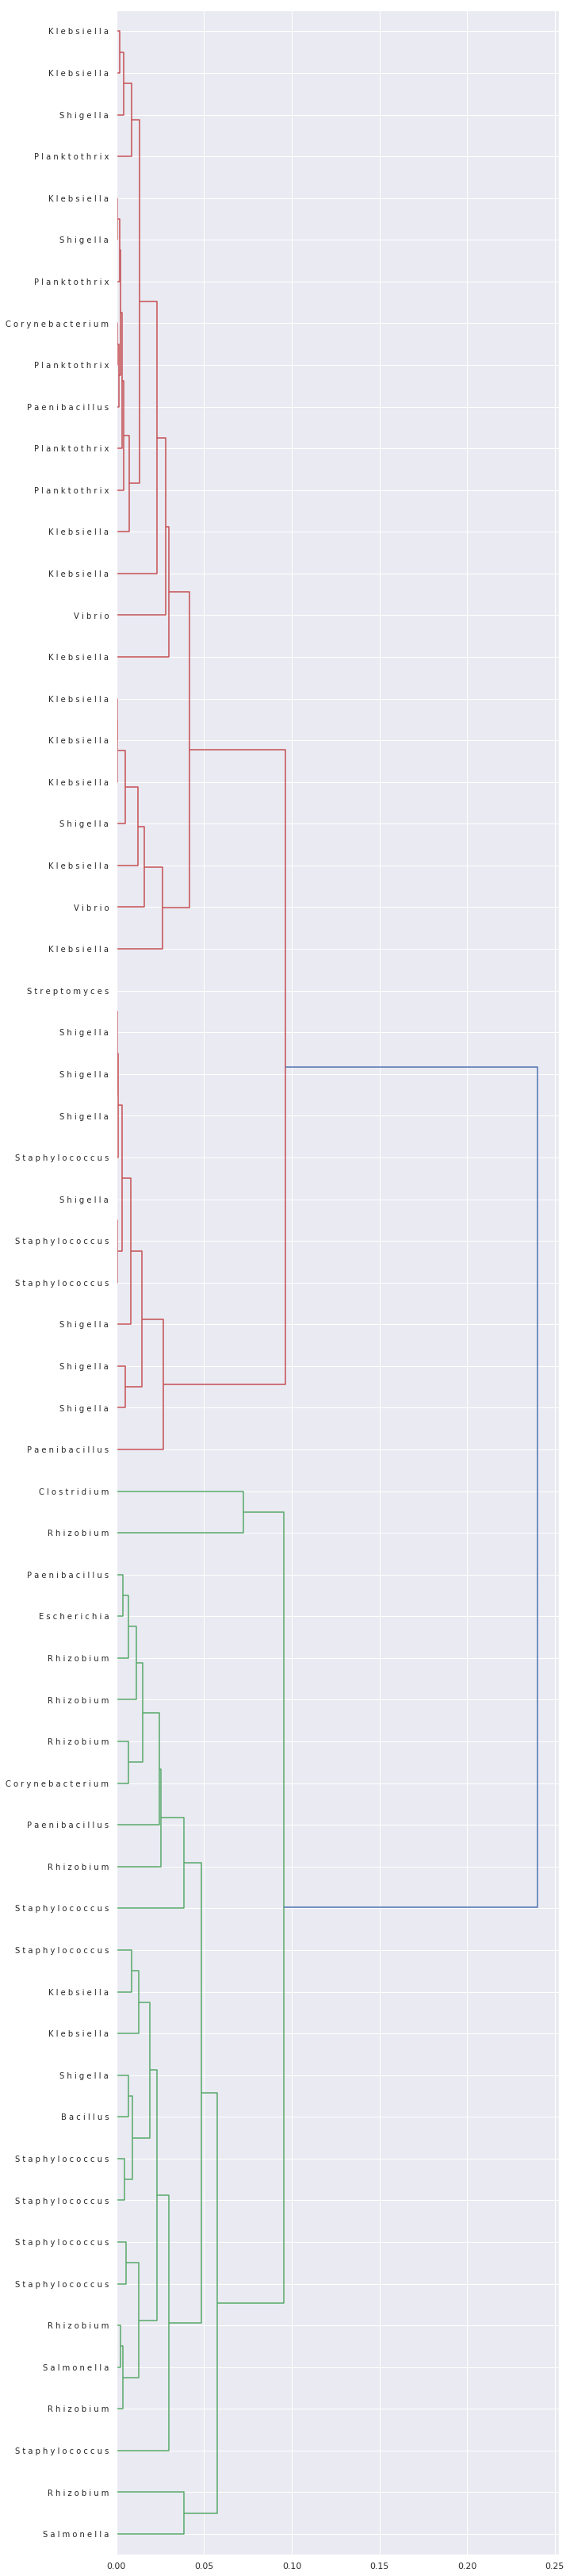

In [60]:
linked = linkage(X_df,method="complete", metric="cosine")

fig=plt.figure(figsize=(10, 59)) 
ax1 = fig.add_subplot(111)

htree = dendrogram(linked,  
            ax=ax1,
            orientation='right',
            p=300,
            truncate_mode='lastp',
            leaf_font_size = 10,
            labels=labelList,
            distance_sort='descending',
            show_contracted=True,       
            show_leaf_counts=True)

In [61]:

vocab=list(np.unique(labelList))
y=[vocab.index(x) for x in labelList]

colors = plt.cm.Set1(range(len(vocab)))

In [62]:
vocab

['B a c i l l u s',
 'C l o s t r i d i u m',
 'C o r y n e b a c t e r i u m',
 'E s c h e r i c h i a',
 'K l e b s i e l l a',
 'P a e n i b a c i l l u s',
 'P l a n k t o t h r i x',
 'R h i z o b i u m',
 'S a l m o n e l l a',
 'S h i g e l l a',
 'S t a p h y l o c o c c u s',
 'S t r e p t o m y c e s',
 'V i b r i o']

In [63]:
tsne = manifold.TSNE(init='pca',metric="cosine",random_state=0)
X_tsne = tsne.fit_transform(log_scale(X))

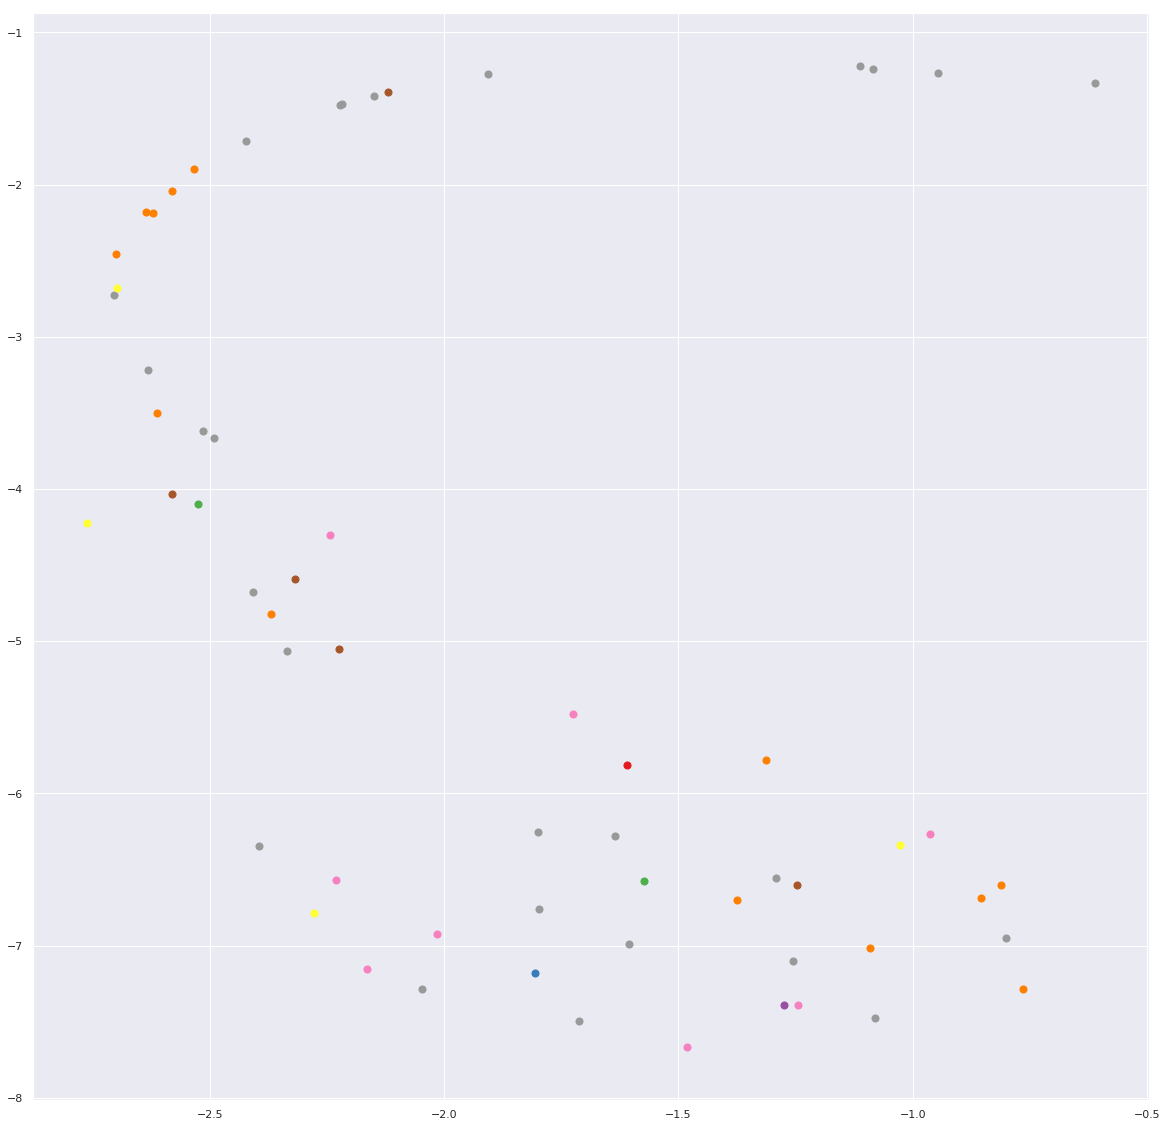

In [64]:
fig = plt.figure(figsize=(20,20))
ax = fig.add_subplot(111)
for i in range(X_tsne.shape[0]):
        plt.scatter(x=X_tsne[i,0],y=X_tsne[i,1],marker=".",s=200,color=colors[y[i]])
plt.show()

In [46]:
sorted(neighbors.VALID_METRICS['brute']) 

['braycurtis',
 'canberra',
 'chebyshev',
 'cityblock',
 'correlation',
 'cosine',
 'cosine',
 'dice',
 'euclidean',
 'hamming',
 'jaccard',
 'kulsinski',
 'l1',
 'l2',
 'mahalanobis',
 'manhattan',
 'matching',
 'minkowski',
 'precomputed',
 'rogerstanimoto',
 'russellrao',
 'seuclidean',
 'sokalmichener',
 'sokalsneath',
 'sqeuclidean',
 'wminkowski',
 'yule']

In [23]:
all_fastas = sequence.Dna2VecList.from_folder("/data/genomes/GenSeq_fastas/train").descriptions
inventory = pd.DataFrame(data=[l.split()[1:3] for l in all_fastas], columns=["genus","species" ]).groupby(["genus", "species"]).agg({"species": "count"})
inventory.columns=["count"]
inventory

count
genus            species                      
Bacillus         cereus                      2
                 coahuilensis              138
                 eiseniae                    9
                 krulwichiae                 1
                 mannanilyticus            108
                 massilioanorexius         120
                 panaciterrae              189
                 psychrosaccharolyticus    265
                 solani                     12
                 subterraneus              208
                 vallismortis               80
Clostridium      aceticum                    2
                 amylolyticum               20
                 butyricum                   2
                 chauvoei                    1
                 haemolyticum              234
Corynebacterium  accolens                   38
                 atypicum                    2
                 doosanense                  2
                 genitalium                  1
                 glucuronolyticum           41
                 imitans                     1
                 timonense                  18
Enterobacter     aerogenes                   1
Escherichia      albertii                    1
                 fergusonii                  2
                 marmotae                  130
Klebsiella       oxytoca                    12
                 quasipneumoniae             3
                 variicola                   1
...                                        ...
Shigella         boydii                      6
                 dysenteriae                 3
                 sonnei                      5
Staphylococcus   agnetis                     2
                 aureus                      1
                 hyicus                      1
                 intermedius               286
                 warneri                     9
                 xylosus                     2
Stenotrophomonas acidaminiphila              1
                 ginsengisoli               99
                 koreensis                  58
                 pavanii                    17
                 rhizophila                  1
Streptococcus    acidominimus              111
                 azizii                     43
                 entericus                  33
                 himalayensis                1
                 minor                      33
                 oralis                      1
Streptomyces     albidoflavus              115
                 ambofaciens                 2
                 antibioticus              343
                 antioxidans               282
                 filamentosus                1
Vibrio           aerogenes                  77
                 celticus                  196
                 europaeus                  10
                 ruber                     103
                 xiamenensis                82

[88 rows x 1 columns]

In [24]:
[i.split()[1:3] for i in all_fastas if  "chromo" in i]

[['Vibrio', 'europaeus'],
 ['Vibrio', 'europaeus'],
 ['Vibrio', 'europaeus'],
 ['Vibrio', 'europaeus'],
 ['Vibrio', 'europaeus'],
 ['Vibrio', 'europaeus'],
 ['Vibrio', 'europaeus'],
 ['Listeria', 'monocytogenes'],
 ['Shigella', 'sonnei'],
 ['Escherichia', 'fergusonii'],
 ['Corynebacterium', 'genitalium'],
 ['Pseudomonas', 'alcaliphila'],
 ['Clostridium', 'chauvoei'],
 ['Pseudomonas', 'asplenii'],
 ['Bacillus', 'cereus'],
 ['Planktothrix', 'agardhii'],
 ['Staphylococcus', 'aureus'],
 ['Streptococcus', 'himalayensis'],
 ['Enterobacter', 'aerogenes'],
 ['Bacillus', 'krulwichiae'],
 ['Clostridium', 'butyricum'],
 ['Clostridium', 'butyricum'],
 ['Shigella', 'dysenteriae']]

In [25]:
[i for i in all_fastas if  "chromo" in i]

['NZ_LUAX01000001.1 Vibrio europaeus strain PP-638 chromosome 1 map unlocalized chr1_1, whole genome shotgun sequence',
 'NZ_LUAX01000002.1 Vibrio europaeus strain PP-638 chromosome 1 map unlocalized chr1_2, whole genome shotgun sequence',
 'NZ_LUAX01000003.1 Vibrio europaeus strain PP-638 chromosome 1 map unlocalized chr1_3, whole genome shotgun sequence',
 'NZ_LUAX01000004.1 Vibrio europaeus strain PP-638 chromosome 1 map unlocalized chr1_4, whole genome shotgun sequence',
 'NZ_LUAX01000005.1 Vibrio europaeus strain PP-638 chromosome 1 map unlocalized chr1_5, whole genome shotgun sequence',
 'NZ_LUAX01000006.1 Vibrio europaeus strain PP-638 chromosome 1 map unlocalized chr1_6, whole genome shotgun sequence',
 'NZ_LUAX01000007.1 Vibrio europaeus strain PP-638 chromosome 2 map unlocalized chr2, whole genome shotgun sequence',
 'NC_003210.1 Listeria monocytogenes EGD-e chromosome, complete genome',
 'NC_016822.1 Shigella sonnei 53G main chromosome, complete genome',
 'NC_011740.1 Escher